In [52]:
import torch
from fastprogress import master_bar, progress_bar
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
import random

In [53]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [54]:
class TCNs(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, is_sequence):
        super(TCNs, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.is_sequence = is_sequence

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)

        # if we want output as the same length as the input
        if self.is_sequence:
            o = self.linear(y1.transpose(1, 2))

        # if we only want the output from the last time step
        else:
            o = self.linear(y1[:, :, -1])
        return o

In [55]:
tcn = TCNs(2, 1, [2], 3, 0.2, True)
history = 4
tcn.train()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(tcn.parameters(), lr= 1e-3,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100,factor =0.5 ,min_lr=1e-7, eps=1e-08)
f_lst = ['des_dx', 'x', 'dx', 'torque']
random.seed(10)

In [56]:
def create_df(f):
    df = pd.DataFrame([line.strip().split() for line in f.readlines()])
    df = df[[0, 1, 3, 6]]
    df.columns = f_lst
    df['vel_error'] = df['des_dx'].astype(float) - df['dx'].astype(float)
    return df

In [57]:
def create_xy(df, h = history):
    X = np.array(df[['x', 'vel_error']]).astype('float')
    
    X = np.array([[[X[i - j][k] for j in range(h - 1, -1, -1)] for k in range(2)] for i in range(h - 1, len(X))])
    
    
    
    #g = np.array([[[0, 0], [0, 0], X[0]], [[0, 0], X[0], X[1]]])
    
    #X = np.concatenate([g, X])
    y = np.array(df[['torque']]).astype('float')[(h - 1):]
    return (X, y)

In [58]:
with open('/Users/tarsur909/Documents/PythonStuff/data/data1.0.txt') as f:
        df = create_df(f)

X, y = create_xy(df)
count = 1
#for n in range(1, 100):
lst = [i for i in range(1, 100)]
sample = random.sample(lst, 99)
train = []
test = []
for n in sample:
    if count <= 36:
        try: 
            with open('/Users/tarsur909/Documents/PythonStuff/data/data0.' + str(n) + '.txt') as f:
                temp_df = create_df(f) 
            tempX, tempy = create_xy(temp_df)
            X = np.concatenate([X, tempX])
            y = np.concatenate([y, tempy])
            train.append(n)
            count += 1
        except:
            continue
    else:
        try: 
            with open('/Users/tarsur909/Documents/PythonStuff/data/data0.' + str(n) + '.txt') as f:
                temp_df = create_df(f)
            test.append(n)
        except:
            continue
                

In [69]:
y.shape

(8734, 1)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    
X_train = Variable(torch.tensor(X_train))
output = tcn(X_train.float())
output.shape

torch.Size([6987, 4, 1])

In [62]:
def train(model, X, y, epochs = 500, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    
    X_train = Variable(torch.tensor(X_train))
    X_test = Variable(torch.tensor(X_test))
    y_train = Variable(torch.tensor(y_train))
    y_test = Variable(torch.tensor(y_test))
    
    for i in progress_bar(range(1, 501)):
        model.train()
        output = model(X_train.float())
        optimizer.zero_grad()
        
        loss = criterion(output, y_train.float())
        loss.backward()
        optimizer.step()
        
        lstm.eval()
        valid = model(X_test.float())
        val_loss = criterion(valid, y_test.float())
        scheduler.step(val_loss)
    
        if i == 1 or i % 50 == 0:
            print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(i, loss.cpu().item(),val_loss.cpu().item()))
    

In [63]:
train(tcn, X, y)

/Users/tarsur909/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([6987, 1])) that is different to the input size (torch.Size([6987, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (4) must match the size of tensor b (6987) at non-singleton dimension 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    
X_train = Variable(torch.tensor(X_train))
X_test = Variable(torch.tensor(X_test))
y_train = Variable(torch.tensor(y_train))
y_test = Variable(torch.tensor(y_test))
    
    
for i in progress_bar(range(1, 501)):
    lstm.train()
    output = lstm(X_train.float())
    optimizer.zero_grad()
        
    loss = criterion(output, y_train.float())
    loss.backward()
    optimizer.step()
        
    lstm.eval()
    valid = lstm(X_test.float())
    val_loss = criterion(valid, y_test.float())
    scheduler.step(val_loss)
    
    if i == 1 or i % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(i, loss.cpu().item(),val_loss.cpu().item()))

Epoch: 1, loss: 0.16403 valid loss:  0.16434 


In [70]:
def graph_predictions(data, title):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    i = 0
    j = 0
    fig.suptitle('Graphs for ' + title + ' Data')
    
    for n in data:
        if i < 3:
    
            with open('/Users/tarsur909/Documents/PythonStuff/data/data' + str(format(n / 100.0, '.2f')) + '.txt') as f:
                df = create_df(f)

            X, y = create_xy(df)
            lstm.eval()
            X = Variable(torch.tensor(X))
            whole = lstm(X.float())
            whole = whole.detach().numpy()
            whole = whole.flatten()
            result = pd.DataFrame(data = {'predictions': whole, 'real': y.flatten()})
    
            sns.lineplot(ax = axes[i, j], data = result).set(title='Des Vel of ' + str(format(n / 100.0, '.2f')))
    
            j += 1
            
            if j > 2:
                j = 0
                i += 1
        else: 
            break
            
        

NameError: name 'lstm' is not defined

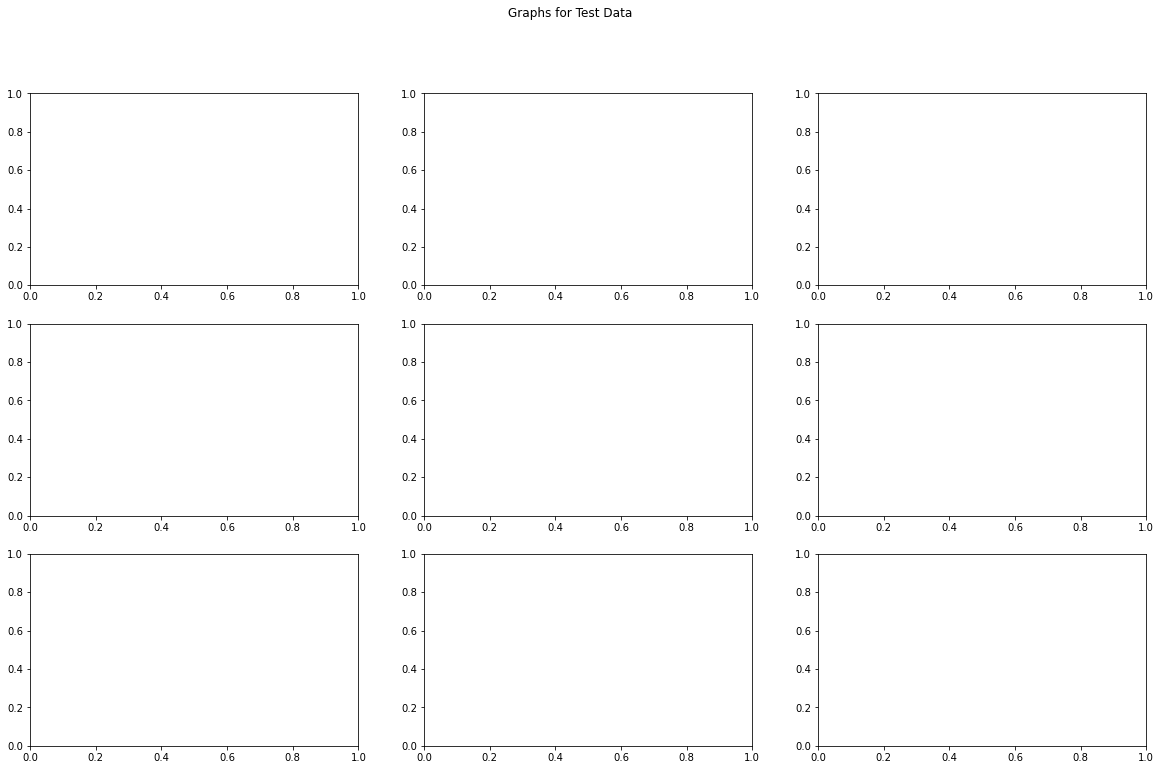

In [71]:
graph_predictions(test, 'Test')

In [ ]:
graph_predictions(train, 'Train')